In [1]:

import ahrs
import requests
import zipfile
import io
import numpy as np


# Function to download the zip file
def download_zip(url, save_path):
    response = requests.get(url)
    with open(save_path, 'wb') as f:
        f.write(response.content)


# Function to read data from 'imu.txt' into arrays for each column
def read_imu_data(zip_path):
    serial_num = []
    timestamps = []
    wx_values = []
    wy_values = []
    wz_values = []
    ax_values = []
    ay_values = []
    az_values = []

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open('imu.txt') as imu_file:
            next(imu_file)  # Skip the first line
            for line in imu_file:
                line = line.decode('utf-8').strip().split()
                sn, ts, wx, wy, wz, ax, ay, az = map(float, line)
                serial_num.append(sn)
                timestamps.append(ts)
                wx_values.append(wx)
                wy_values.append(wy)
                wz_values.append(wz)
                ax_values.append(ax)
                ay_values.append(ay)
                az_values.append(az)

    imu_data = np.zeros((len(ax_values),7))
    imu_data[:, 0] = timestamps
    imu_data[:, 1] = wx_values
    imu_data[:, 2] = wy_values
    imu_data[:, 3] = wz_values
    imu_data[:, 4] = ax_values
    imu_data[:, 5] = ay_values
    imu_data[:, 6] = az_values
    # Convert lists to numpy arrays
    serial_num = np.array(serial_num)
    timestamps = np.array(timestamps)
    wx_values = np.array(wx_values)
    wy_values = np.array(wy_values)
    wz_values = np.array(wz_values)
    ax_values = np.array(ax_values)
    ay_values = np.array(ay_values)
    az_values = np.array(az_values)
    print(imu_data)
    return serial_num, timestamps, wx_values, wy_values, wz_values, ax_values, ay_values, az_values, imu_data

In [2]:

## URL of the zip file
#zip_url = 'http://rpg.ifi.uzh.ch/datasets/uzh-fpv-newer-versions/v3/indoor_forward_9_davis_with_gt.zip'
zip_url = 'http://rpg.ifi.uzh.ch/datasets/uzh-fpv-newer-versions/v3/indoor_forward_3_davis_with_gt.zip'
## Path to save the downloaded zip file
zip_save_path = 'indoor_forward_3_davis_with_gt.zip'
zip_save = "C:\FinalProject\indoor_forward_3_davis_with_gt.zip"
## Download the zip file
# download_zip(zip_url, zip_save_path)

## Read data from the 'imu.txt' file into arrays for each column
samp_num, timestamps, wx_values, wy_values, wz_values, ax_values, ay_values, az_values, imu_data = read_imu_data(zip_save)

[[ 1.54082024e+09 -6.49811264e-02 -5.32632218e-03 ...  6.89765625e-01
  -9.81958008e+00  1.00590820e+00]
 [ 1.54082024e+09 -6.49811264e-02 -5.32632218e-03 ...  6.94555664e-01
  -9.81479004e+00  1.01069824e+00]
 [ 1.54082024e+09 -6.39158620e-02 -4.26105748e-03 ...  7.08925781e-01
  -9.81479004e+00  1.01069824e+00]
 ...
 [ 1.54082033e+09 -9.69390554e-02  5.32632218e-03 ...  1.12086914e+00
  -9.80520996e+00  9.81958008e-01]
 [ 1.54082033e+09 -9.90695842e-02  4.26105748e-03 ...  1.07775879e+00
  -9.81958008e+00  1.05380859e+00]
 [ 1.54082033e+09 -9.80043198e-02  5.32632218e-03 ...  1.05859863e+00
  -9.84832031e+00  1.14481934e+00]]


Error: 576.355 m


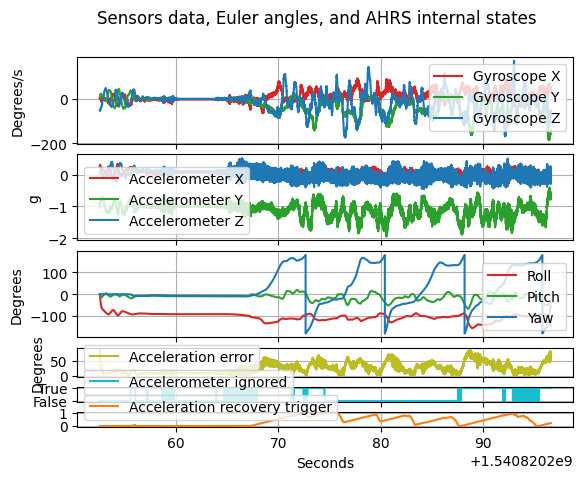

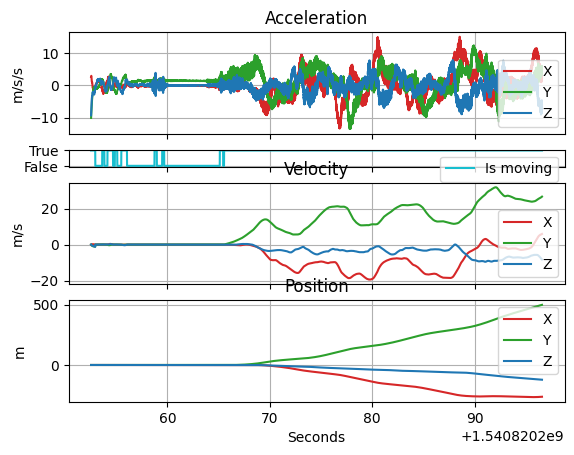

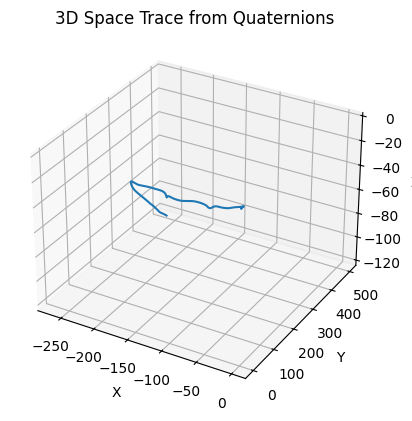

In [14]:
import matplotlib.pyplot as plt

from dataclasses import dataclass
from matplotlib import animation
from scipy.interpolate import interp1d
import imufusion
import matplotlib.pyplot as pyplot
import numpy

# Import sensor data ("short_walk.csv" or "long_walk.csv")
# sample_rate = 400  # 400 Hz
# data = numpy.genfromtxt("short_walk.csv", delimiter=",", skip_header=1)
# timestamp = data[:, 0]
# gyroscope = data[:, 1:4]
# accelerometer = data[:, 4:7]


# 
sample_rate = 1000  # 400 Hz

timestamp = imu_data[16000:60000, 0]
gyroscope = np.degrees(imu_data[16000:60000, 1:4])    #to degrees
# accelerometer = ((imu_data[16000:60000, 4:7])/9.80665)       # to g units
accelerometer = ((imu_data[16000:60000, 4:7])/9.81)       # to g units

# Plot sensor data
figure, axes = pyplot.subplots(nrows=6, sharex=True, gridspec_kw={"height_ratios": [6, 6, 6, 2, 1, 1]})

figure.suptitle("Sensors data, Euler angles, and AHRS internal states")

axes[0].plot(timestamp, gyroscope[:, 0], "tab:red", label="Gyroscope X")
axes[0].plot(timestamp, gyroscope[:, 1], "tab:green", label="Gyroscope Y")
axes[0].plot(timestamp, gyroscope[:, 2], "tab:blue", label="Gyroscope Z")
axes[0].set_ylabel("Degrees/s")
axes[0].grid()
axes[0].legend()

axes[1].plot(timestamp, accelerometer[:, 0], "tab:red", label="Accelerometer X")
axes[1].plot(timestamp, accelerometer[:, 1], "tab:green", label="Accelerometer Y")
axes[1].plot(timestamp, accelerometer[:, 2], "tab:blue", label="Accelerometer Z")
axes[1].set_ylabel("g")
axes[1].grid()
axes[1].legend()

# Instantiate AHRS algorithms
offset = imufusion.Offset(sample_rate)
ahrs = imufusion.Ahrs()

ahrs.settings = imufusion.Settings(imufusion.CONVENTION_NWU,
                                   0.5,  # gain
                                   2000,  # gyroscope range
                                   10,  # acceleration rejection
                                   0,  # magnetic rejection
                                   5 * sample_rate)  # rejection timeout = 5 seconds

# Process sensor data
delta_time = numpy.diff(timestamp, prepend=timestamp[0])

euler = numpy.empty((len(timestamp), 3))
internal_states = numpy.empty((len(timestamp), 3))
acceleration = numpy.empty((len(timestamp), 3))

for index in range(len(timestamp)):
    gyroscope[index] = offset.update(gyroscope[index])

    ahrs.update_no_magnetometer(gyroscope[index], accelerometer[index], delta_time[index])

    euler[index] = ahrs.quaternion.to_euler()

    ahrs_internal_states = ahrs.internal_states
    internal_states[index] = numpy.array([ahrs_internal_states.acceleration_error,
                                          ahrs_internal_states.accelerometer_ignored,
                                          ahrs_internal_states.acceleration_recovery_trigger])

    acceleration[index] = 9.81 * ahrs.earth_acceleration  # convert g to m/s/s

# Plot Euler angles
axes[2].plot(timestamp, euler[:, 0], "tab:red", label="Roll")
axes[2].plot(timestamp, euler[:, 1], "tab:green", label="Pitch")
axes[2].plot(timestamp, euler[:, 2], "tab:blue", label="Yaw")
axes[2].set_ylabel("Degrees")
axes[2].grid()
axes[2].legend()

# Plot internal states
axes[3].plot(timestamp, internal_states[:, 0], "tab:olive", label="Acceleration error")
axes[3].set_ylabel("Degrees")
axes[3].grid()
axes[3].legend()

axes[4].plot(timestamp, internal_states[:, 1], "tab:cyan", label="Accelerometer ignored")
pyplot.sca(axes[4])
pyplot.yticks([0, 1], ["False", "True"])
axes[4].grid()
axes[4].legend()

axes[5].plot(timestamp, internal_states[:, 2], "tab:orange", label="Acceleration recovery trigger")
axes[5].set_xlabel("Seconds")
axes[5].grid()
axes[5].legend()

# Plot acceleration
_, axes = pyplot.subplots(nrows=4, sharex=True, gridspec_kw={"height_ratios": [6, 1, 6, 6]})

axes[0].plot(timestamp, acceleration[:, 0], "tab:red", label="X")
axes[0].plot(timestamp, acceleration[:, 1], "tab:green", label="Y")
axes[0].plot(timestamp, acceleration[:, 2], "tab:blue", label="Z")
axes[0].set_title("Acceleration")
axes[0].set_ylabel("m/s/s")
axes[0].grid()
axes[0].legend()

# Identify moving periods
is_moving = numpy.empty(len(timestamp))

for index in range(len(timestamp)):
    is_moving[index] = numpy.sqrt(acceleration[index].dot(acceleration[index])) > 3  # threshold = 3 m/s/s

# margin = int(0.1 * sample_rate)  # 100 ms
margin = int(0.1 * sample_rate)  

for index in range(len(timestamp) - margin):
    is_moving[index] = any(is_moving[index:(index + margin)])  # add leading margin

for index in range(len(timestamp) - 1, margin, -1):
    is_moving[index] = any(is_moving[(index - margin):index])  # add trailing margin

# Plot moving periods
axes[1].plot(timestamp, is_moving, "tab:cyan", label="Is moving")
pyplot.sca(axes[1])
pyplot.yticks([0, 1], ["False", "True"])
axes[1].grid()
axes[1].legend()

# Calculate velocity (includes integral drift)
velocity = numpy.zeros((len(timestamp), 3))

for index in range(len(timestamp)):
    if is_moving[index]:  # only integrate if moving
        velocity[index] = velocity[index - 1] + delta_time[index] * acceleration[index]

# Find start and stop indices of each moving period
is_moving_diff = numpy.diff(is_moving, append=is_moving[-1])


@dataclass
class IsMovingPeriod:
    start_index: int = -1
    stop_index: int = -1


is_moving_periods = []
is_moving_period = IsMovingPeriod()

for index in range(len(timestamp)):
    if is_moving_period.start_index == -1:
        if is_moving_diff[index] == 1:
            is_moving_period.start_index = index

    elif is_moving_period.stop_index == -1:
        if is_moving_diff[index] == -1:
            is_moving_period.stop_index = index
            is_moving_periods.append(is_moving_period)
            is_moving_period = IsMovingPeriod()

# Remove integral drift from velocity
velocity_drift = numpy.zeros((len(timestamp), 3))

for is_moving_period in is_moving_periods:
    start_index = is_moving_period.start_index
    stop_index = is_moving_period.stop_index

    t = [timestamp[start_index], timestamp[stop_index]]
    x = [velocity[start_index, 0], velocity[stop_index, 0]]
    y = [velocity[start_index, 1], velocity[stop_index, 1]]
    z = [velocity[start_index, 2], velocity[stop_index, 2]]

    t_new = timestamp[start_index:(stop_index + 1)]

    velocity_drift[start_index:(stop_index + 1), 0] = interp1d(t, x)(t_new)
    velocity_drift[start_index:(stop_index + 1), 1] = interp1d(t, y)(t_new)
    velocity_drift[start_index:(stop_index + 1), 2] = interp1d(t, z)(t_new)

velocity = velocity - velocity_drift

# Plot velocity
axes[2].plot(timestamp, velocity[:, 0], "tab:red", label="X")
axes[2].plot(timestamp, velocity[:, 1], "tab:green", label="Y")
axes[2].plot(timestamp, velocity[:, 2], "tab:blue", label="Z")
axes[2].set_title("Velocity")
axes[2].set_ylabel("m/s")
axes[2].grid()
axes[2].legend()

# Calculate position
position = numpy.zeros((len(timestamp), 3))

for index in range(len(timestamp)):
    position[index] = position[index - 1] + delta_time[index] * velocity[index]

# Plot position
axes[3].plot(timestamp, position[:, 0], "tab:red", label="X")
axes[3].plot(timestamp, position[:, 1], "tab:green", label="Y")
axes[3].plot(timestamp, position[:, 2], "tab:blue", label="Z")
axes[3].set_title("Position")
axes[3].set_xlabel("Seconds")
axes[3].set_ylabel("m")
axes[3].grid()
axes[3].legend()

# Print error as distance between start and final positions
print("Error: " + "{:.3f}".format(numpy.sqrt(position[-1].dot(position[-1]))) + " m")


positions = position
# Plot the 3D trace
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Space Trace from Quaternions')
plt.show()




# Create 3D animation (takes a long time, set to False to skip)
if False:
    figure = pyplot.figure(figsize=(10, 10))

    axes = pyplot.axes(projection="3d")
    axes.set_xlabel("m")
    axes.set_ylabel("m")
    axes.set_zlabel("m")

    x = []
    y = []
    z = []

    scatter = axes.scatter(x, y, z)

    fps = 30
    samples_per_frame = int(sample_rate / fps)

    def update(frame):
        index = frame * samples_per_frame

        axes.set_title("{:.3f}".format(timestamp[index]) + " s")

        x.append(position[index, 0])
        y.append(position[index, 1])
        z.append(position[index, 2])

        scatter._offsets3d = (x, y, z)

        if (min(x) != max(x)) and (min(y) != max(y)) and (min(z) != max(z)):
            axes.set_xlim3d(min(x), max(x))
            axes.set_ylim3d(min(y), max(y))
            axes.set_zlim3d(min(z), max(z))

            axes.set_box_aspect((numpy.ptp(x), numpy.ptp(y), numpy.ptp(z)))

        return scatter

    anim = animation.FuncAnimation(figure, update,
                                   frames=int(len(timestamp) / samples_per_frame),
                                   interval=1000 / fps,
                                   repeat=False)

    anim.save("animation.gif", writer=animation.PillowWriter(fps))

pyplot.show()